In [218]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [219]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
seed_everything()

In [220]:
train = pd.read_csv("./input/train_data.csv")
test = pd.read_csv("./input/test_data.csv")

In [221]:
target_col = "salary"
target = train[target_col]
train.drop(columns=[target_col], inplace=True)

## 特徴量エンジニアリング

In [222]:
def preprocess(df):
    df["area"] = LabelEncoder().fit_transform(df["area"])
    return df 

In [223]:
def fea_eng(df):
    #数値系
    #家族の人数
    df["family_num"] = df["partner"] + df["num_child"]
    
    #年間の勤務時間
    df["work_time_per_year"] = 8*245*df["service_length"] + 12*df["overtime"]*df["service_length"]
    
    #年間の勤務日数
    df["work_day"] = df["work_time_per_year"]/24
    
    #1日の勤務時間
    
    
    #年間の自由時間
    df["free_time_per_year"] = 24*365 - 8*365 - df["study_time"]*48 - df["overtime"]*12 - df["commute"]*365
    
    #卒業年齢
    grad_age = []
    for i, school in enumerate(df["education"]):
        if school == 0:
            grad_age.append(18)
        elif school == 1:
            grad_age.append(20)
        elif school == 2:
            grad_age.append(22)
        elif school == 3:
            grad_age.append(24)
        else:
            grad_age.append(27)
    df["grad_age"] = grad_age
    
    #カテゴリ変数系
    #年齢層のラベル
    age_gen = []
    for i, age in enumerate(df["age"]):
        if age > 10 and age < 20:
            age_gen.append(1)
        elif age >= 20 and age < 30:
            age_gen.append(2)
        elif age >= 30 and age < 40:
            age_gen.append(3)
        elif age >= 40 and age < 50:
            age_gen.append(4)
        elif age >= 50 and age < 60:
            age_gen.append(5)
        else:
            age_gen.append(6)
    df["age_generation"] = age_gen
    
    #中途採用フラグ
    mid_rec = []
    for age, ser_len, grad_age in zip(df["age"], df["service_length"], df["grad_age"] ):
        if ser_len != age-grad_age:
            mid_rec.append(1)
        else:
            mid_rec.append(0)
    df["mid_rec_flag"] = mid_rec
    
    return df

In [224]:
drop_cols = ["id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [226]:
%%time
train_df = preprocess(train)
train_df = fea_eng(train)

test_df = preprocess(test)
test_df = fea_eng(test)

CPU times: user 103 ms, sys: 24.2 ms, total: 127 ms
Wall time: 197 ms


In [227]:
train.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,family_num,work_time_per_year,work_day,work_time_per_day,free_time_per_year,grad_age,age_generation,mid_rec_flag
0,1,44,24,2,1,2,1,24,2.0,1.6,9.2,3,49689.6,2070.400000,24.0,5049.6,20,4,0
1,2,31,10,1,0,0,0,13,9.0,0.7,12.4,0,27414.4,1142.266667,24.0,5003.7,18,3,0
2,2,36,14,1,0,0,2,14,4.0,0.4,16.9,0,30279.2,1261.633333,24.0,5299.2,22,3,0
3,0,22,26,2,0,0,0,4,3.0,0.4,6.1,0,8132.8,338.866667,24.0,5476.8,18,2,0
4,0,25,46,2,0,0,1,5,3.0,0.2,4.9,0,10094.0,420.583333,24.0,5564.2,20,2,0


In [230]:
test.head()

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,family_num,work_time_per_year,work_day,work_time_per_day,free_time_per_year,grad_age,age_generation,mid_rec_flag
0,3,39,46,2,1,5,1,19,1.0,1.8,14.2,6,40477.6,1686.566667,24.0,4964.6,20,3,0
1,1,31,11,1,0,0,4,0,0.0,0.5,18.6,0,0.0,0.000000,NaN,5434.3,27,3,1
2,0,20,24,2,1,2,0,2,2.0,1.2,2.3,3,3975.2,165.633333,24.0,5278.4,18,2,0
3,0,28,0,2,0,0,0,10,3.0,0.3,0.0,0,19600.0,816.666667,24.0,5586.5,18,2,0
4,1,41,23,2,0,0,0,23,3.0,0.5,10.1,0,47867.6,1994.483333,24.0,5392.3,18,4,0


In [231]:
cat_features_cols = ["position", "area", "sex", "partner", "education", "age_generation", "mid_rec_flag"]
cat_features_idx = [idx for idx, col in enumerate(train.columns) if col in cat_features_cols]
cat_features_idx

[0, 2, 3, 4, 6, 17, 18]

In [232]:
features = [c for c in train.columns if c not in ['id', 'salary']]
target = target.map(np.log1p)

In [233]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'fair',
    'metric': 'fair',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators':20000,
    'early_stopping_rounds':200,
    'seed': 42
}

In [234]:
folds = KFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(params, 
                         trn_data, 
                         num_round, 
                         valid_sets = [trn_data, val_data], 
                         verbose_eval =1000, 
                         early_stopping_rounds = 3000,
                         categorical_feature = cat_features_idx)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_absolute_error(np.expm1(target), np.expm1(oof))))

Fold 1


/Users/ryomaekura/opt/anaconda3/envs/Kaggle/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/ryomaekura/opt/anaconda3/envs/Kaggle/lib/python3.7/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/ryomaekura/opt/anaconda3/envs/Kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 6, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/ryomaekura/opt/anaconda3/envs/Kaggle/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_fe

Training until validation scores don't improve for 200 rounds.
[1000]	training's fair: 0.00296464	valid_1's fair: 0.00368328
[2000]	training's fair: 0.0024599	valid_1's fair: 0.003601
[3000]	training's fair: 0.00210861	valid_1's fair: 0.00358035
Early stopping, best iteration is:
[2875]	training's fair: 0.00214751	valid_1's fair: 0.00357534
Fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's fair: 0.002998	valid_1's fair: 0.00364853
[2000]	training's fair: 0.00247707	valid_1's fair: 0.00353567
Early stopping, best iteration is:
[2316]	training's fair: 0.00235288	valid_1's fair: 0.00352327
Fold 3
Training until validation scores don't improve for 200 rounds.
[1000]	training's fair: 0.00297244	valid_1's fair: 0.00361198
[2000]	training's fair: 0.002458	valid_1's fair: 0.00353978
Early stopping, best iteration is:
[2470]	training's fair: 0.0022812	valid_1's fair: 0.00352494
Fold 4
Training until validation scores don't improve for 200 rounds.
[1000]	tra

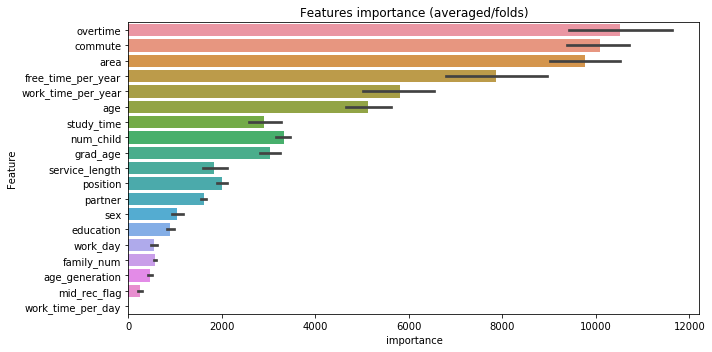

In [235]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [192]:
predictions = np.expm1(predictions)
pd.DataFrame({"id": range(len(predicts)), "y": predictions }).to_csv("./output/kernel_lgbm_fold10-averaging_fea-eng2.csv", index=False)